In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
from matplotlib import pyplot as plt

In [4]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
X_train = X_train.drop(["Velicina"],axis = 1)
X_test = X_test.drop(["Velicina"],axis = 1)

%store -r X_train_SMOTE
%store -r y_train_SMOTE
X_train_SMOTE = pd.DataFrame(X_train_SMOTE.iloc[:, :-1], columns=X_train_SMOTE.columns[:-1])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train_encoded, test_size=0.15, random_state=42, stratify=y_train_encoded
)

num_classes = len(np.unique(y_train))


C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [6]:
%store -r class_weight
%store -r X_train_SMOTE
%store -r y_train_SMOTE
X_train_SMOTE = pd.DataFrame(X_train_SMOTE.iloc[:, :-1], columns=X_train_SMOTE.columns[:-1])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_SMOTE)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_SMOTE)
y_test_encoded = label_encoder.transform(y_test)

from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train_encoded, test_size=0.15, random_state=42, stratify=y_train_encoded
)

num_classes = len(np.unique(y_train))

C:\Users\mihai\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


# Grid search

In [47]:
def create_model(neurons_layer1=10, neurons_layer2=140, num_layers=2, dropout_rate=0.0, optimizer='adam', epochs=100, batch_size=32):
    model = Sequential()
    model.add(Dense(neurons_layer1, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_layer2, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    return model

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'neurons_layer1': [20, 30],
    'neurons_layer2': [64, 140],
    'num_layers': [2, 6],
    'optimizer': ['rmsprop'],
    'dropout_rate': [0.2, 0.4],
    'epochs': [200, 300],
    'batch_size': [32, 64]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(accuracy_score), cv=3, verbose=2)

grid_result = grid.fit(X_train_split, y_train_split)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

best_params = grid_result.best_params_
final_model = create_model(**best_params)

history = final_model.fit(X_train_split, y_train_split, epochs=best_params['epochs'], 
                          batch_size=best_params['batch_size'], validation_data=(X_val_split, y_val_split), 
                          verbose=2)

test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


C:\Users\andje\AppData\Local\Temp\ipykernel_25292\370474042.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, neurons_layer2=64, num_layers=2, optimizer=rmsprop; total time=   2.3s
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, neurons_layer2=64, num_layers=2, optimizer=rmsprop; total time=   2.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, neurons_layer2=64, num_layers=2, optimizer=rmsprop; total time=   2.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, neurons_layer2=64, num_layers=6, optimizer=rmsprop; total time=   4.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, neurons_layer2=64, num_layers=6, optimizer=rmsprop; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, neurons_layer2=64, num_layers=6, optimizer=rmsprop; total time=   4.3s
[CV] END batch_size=32, dropout_rate=0.2, epochs=200, neurons_layer1=20, n

# Prikaz prvih 10 najboljih rezultata

In [49]:
pd.set_option('display.max_colwidth', None)

results_df = pd.DataFrame(grid_result.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

top_10_results = sorted_results.head(10)
print(top_10_results[['params', 'mean_test_score', 'std_test_score']])


                                                                                                                                          params  \
28   {'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 300, 'neurons_layer1': 30, 'neurons_layer2': 64, 'num_layers': 2, 'optimizer': 'rmsprop'}   
11  {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 300, 'neurons_layer1': 20, 'neurons_layer2': 140, 'num_layers': 6, 'optimizer': 'rmsprop'}   
13   {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 300, 'neurons_layer1': 30, 'neurons_layer2': 64, 'num_layers': 6, 'optimizer': 'rmsprop'}   
27  {'batch_size': 32, 'dropout_rate': 0.4, 'epochs': 300, 'neurons_layer1': 20, 'neurons_layer2': 140, 'num_layers': 6, 'optimizer': 'rmsprop'}   
15  {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 300, 'neurons_layer1': 30, 'neurons_layer2': 140, 'num_layers': 6, 'optimizer': 'rmsprop'}   
60   {'batch_size': 64, 'dropout_rate': 0.4, 'epochs': 300, 'neurons_layer1': 30, 'neurons_layer2': 64, 'num_lay

# Hiperparametarsko podešavanje najboljeg modela

In [8]:
def create_model_with_batch_norm(neurons_layer1=30, neurons_layer2=64, num_layers=2, dropout_rate=0.4, optimizer='rmsprop'):
    model = Sequential()
    model.add(Dense(neurons_layer1, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.5))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_layer2, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    return model

Za svaku epohu cuvamo model i izvlacimo najbolji

In [ ]:
model = create_model_with_batch_norm()

checkpoint = ModelCheckpoint('modeli/model_epoch_{epoch:02d}.h5', monitor='accuracy', save_best_only=False)

history = model.fit(X_train_scaled, y_train_encoded, epochs=300, 
                    batch_size=32, verbose=2, callbacks=[checkpoint])

**Model treniran nad podacima na koje su primenjene tezine klasa**

In [8]:
final_model_weight = load_model("best_model_weight.h5")
y_pred = final_model_weight.predict(X_test_scaled)
y_pred_best = np.argmax(y_pred, axis=1)

class_names = label_encoder.classes_

accuracy_best_cw = accuracy_score(y_test_encoded, y_pred_best)
precision_best_cw = precision_score(y_test_encoded, y_pred_best, average='weighted')
recall_best_cw = recall_score(y_test_encoded, y_pred_best, average='weighted')
f1_best_cw = f1_score(y_test_encoded, y_pred_best, average='weighted')

print("Tacnost modela sa najboljim parametrima:", round(accuracy_best_cw, 5))
print("Precision modela sa najboljim parametrima:", round(precision_best_cw, 5))
print("Recall modela sa najboljim parametrima:", round(recall_best_cw, 5))
print("F1 score modela sa najboljim parametrima:", round(f1_best_cw, 5))
#print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

test_loss, test_accuracy = final_model_weight.evaluate(X_test_scaled, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
final_model_weight.summary() 

5/5 [==============================] - 0s 3ms/step
Tacnost modela sa najboljim parametrima: 0.80921
Precision modela sa najboljim parametrima: 0.82805
Recall modela sa najboljim parametrima: 0.80921
F1 score modela sa najboljim parametrima: 0.81415
5/5 [==============================] - 0s 2ms/step - loss: 1.1754 - accuracy: 0.8092
Test Accuracy: 80.92%
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                1950      
                                                                 
 batch_normalization_8 (Bat  (None, 30)                120       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 30)                0         
                                                                 
 dense_13 (Dense)           

**Model treniran nad podacima na kojima je primenjena SMOTE tehnika**

In [7]:
final_model_SMOTE = load_model("best_model_SMOTE.h5")
y_pred = final_model_SMOTE.predict(X_test_scaled)
y_pred_best = np.argmax(y_pred, axis=1)

class_names = label_encoder.classes_

accuracy_best_SMOTE = accuracy_score(y_test_encoded, y_pred_best)
precision_best_SMOTE = precision_score(y_test_encoded, y_pred_best, average='weighted')
recall_best_SMOTE = recall_score(y_test_encoded, y_pred_best, average='weighted')
f1_best_SMOTE = f1_score(y_test_encoded, y_pred_best, average='weighted')

print("Tacnost modela sa najboljim parametrima:", round(accuracy_best_SMOTE, 5))
print("Precision modela sa najboljim parametrima:", round(precision_best_SMOTE, 5))
print("Recall modela sa najboljim parametrima:", round(recall_best_SMOTE, 5))
print("F1 score modela sa najboljim parametrima:", round(f1_best_SMOTE, 5))
#print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

test_loss, test_accuracy = final_model_SMOTE.evaluate(X_test_scaled, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
final_model_SMOTE.summary() 

5/5 [==============================] - 0s 2ms/step
Tacnost modela sa najboljim parametrima: 0.84211
Precision modela sa najboljim parametrima: 0.84744
Recall modela sa najboljim parametrima: 0.84211
F1 score modela sa najboljim parametrima: 0.84154
5/5 [==============================] - 0s 4ms/step - loss: 1.0969 - accuracy: 0.8421
Test Accuracy: 84.21%
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                1950      
                                                                 
 batch_normalization_4 (Bat  (None, 30)                120       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 30)                0         
                                                                 
 dense_7 (Dense)            

# Finalni model

In [5]:
final_model = load_model('best_model1.h5')
y_pred = final_model.predict(X_test_scaled)
y_pred_best = np.argmax(y_pred, axis=1)

class_names = label_encoder.classes_

accuracy_best = accuracy_score(y_test_encoded, y_pred_best)
precision_best = precision_score(y_test_encoded, y_pred_best, average='weighted')
recall_best = recall_score(y_test_encoded, y_pred_best, average='weighted')
f1_best = f1_score(y_test_encoded, y_pred_best, average='weighted')

print("Tacnost modela sa najboljim parametrima:", round(accuracy_best, 5))
print("Precision modela sa najboljim parametrima:", round(precision_best, 5))
print("Recall modela sa najboljim parametrima:", round(recall_best, 5))
print("F1 score modela sa najboljim parametrima:", round(f1_best, 5))
#print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
final_model.summary() 



5/5 [==============================] - 0s 4ms/step
Tacnost modela sa najboljim parametrima: 0.86842
Precision modela sa najboljim parametrima: 0.87959
Recall modela sa najboljim parametrima: 0.86842
F1 score modela sa najboljim parametrima: 0.86733

5/5 [==============================] - 0s 4ms/step - loss: 0.5906 - accuracy: 0.8684
Test Accuracy: 86.84%
Model: "sequential_257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1327 (Dense)          (None, 30)                1950      
                                                                 
 batch_normalization_158 (B  (None, 30)                120       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 30)                0         
                                                                 
 dense_1328 (Dense)     

**Poredjenje modela**

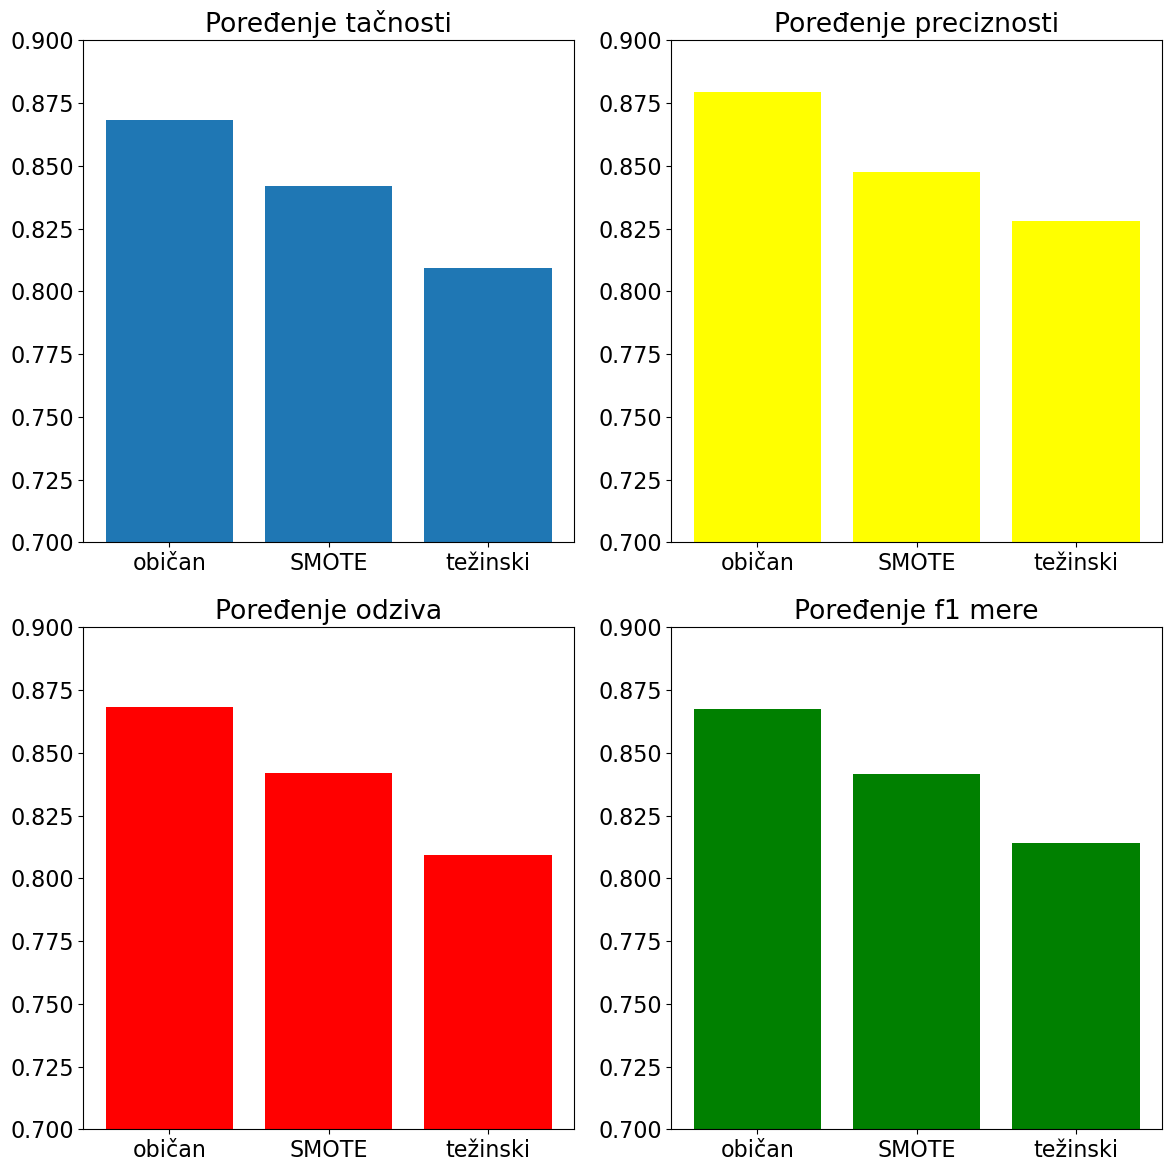

In [9]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.bar(['običan', 'SMOTE', 'težinski'], [accuracy_best, accuracy_best_SMOTE, accuracy_best_cw])
plt.title('Poređenje tačnosti')
plt.ylim(0.7, 0.9)

plt.subplot(2, 2, 2)
plt.bar(['običan', 'SMOTE', 'težinski'], [precision_best, precision_best_SMOTE, precision_best_cw], color='yellow')
plt.title('Poređenje preciznosti')
plt.ylim(0.7, 0.9)

plt.subplot(2, 2, 3)
plt.bar(['običan', 'SMOTE', 'težinski'], [recall_best, recall_best_SMOTE, recall_best_cw], color='red')
plt.title('Poređenje odziva')
plt.ylim(0.7, 0.9)

plt.subplot(2, 2, 4)
plt.bar(['običan', 'SMOTE', 'težinski'], [f1_best, f1_best_SMOTE, f1_best_cw], color='green')
plt.title('Poređenje f1 mere')
plt.ylim(0.7, 0.9)

plt.savefig('NN_poredjenje.png')
plt.tight_layout()
plt.show()

In [10]:
nn_best_accuracy = accuracy_best

In [11]:
%store nn_best_accuracy

Stored 'nn_best_accuracy' (float64)
